In [1]:
import cantera as ct
import numpy as np
import scipy.signal
import os
import scipy.interpolate

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Pt111
# mech_yaml = '/home/moon/uncertainty_estimator/nam29_presentation/cpox_Pt/chem_annotated.yaml'
mech_yaml = '/home/moon/uncertainty_estimator/beef/cpox_Pt/chem_annotated.yaml'

gas = ct.Solution(mech_yaml, 'gas')
surf = ct.Interface(mech_yaml, 'surface1', [gas])

# gas, _ = ct.import_phases(mech_yaml, ["gas", "surface1"])
# surf = ct.Interface(mech_yaml, 'surface1')  # new way

# surf = ct.Interface(mech_yaml,'surface1')
# gas = surf.adjacent['gas']

print(f'This mechanism contains {gas.n_species} gas species and {surf.n_species} surface species')
print(f'This mechanism contains {gas.n_reactions} gas reactions and {surf.n_reactions} surface reactions')

This mechanism contains 24 gas species and 21 surface species
This mechanism contains 62 gas reactions and 145 surface reactions


In [3]:
def get_i_thing(ref_composition, phase):
    for i in range(phase.n_species):
        if phase.species()[i].composition == ref_composition:
            return i
    assert False
    return -1

# Get indices of key species
i_Ar = get_i_thing({'Ar': 1.0}, gas)
i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
i_O2 = get_i_thing({'O': 2.0}, gas)
i_CO2 = get_i_thing({'C': 1.0, 'O': 2.0}, gas)
i_H2O = get_i_thing({'H': 2.0, 'O': 1.0}, gas)
i_H2 = get_i_thing({'H': 2.0}, gas)
i_CO = get_i_thing({'C': 1.0, 'O': 1.0}, gas)
i_C2H4 = get_i_thing({'C': 2.0, 'H': 4.0}, gas)
i_X = get_i_thing({'X': 1.0}, surf)
i_OX = get_i_thing({'X': 1.0, 'O': 1.0}, surf)
i_HX = get_i_thing({'X': 1.0, 'H': 1.0}, surf)
i_CH3X = get_i_thing({'X': 1.0, 'H': 3.0, 'C': 1.0}, surf)

In [4]:
# Make the colors consistent between all mechanism
np.random.seed(400)
color_dict = {
    "{'X': 1.0}": '#1f77b4',
    "{'O': 1.0, 'X': 1.0}": '#ff7f0e',
    "{'H': 1.0, 'X': 1.0}": '#2ca02c',
    "{'H': 1.0, 'O': 1.0, 'X': 1.0}": '#d62728',
    "{'H': 1.0, 'N': 1.0, 'X': 1.0}": '#9467bd',
    "{'N': 1.0, 'O': 1.0, 'X': 2.0}": '#8c564b',
    "{'H': 3.0, 'N': 1.0, 'X': 1.0}": '#e377c2',
    "{'H': 2.0, 'N': 1.0, 'X': 1.0}": '#7f7f7f',
    "{'N': 2.0, 'X': 2.0}": '#bcbd22',
    "{'N': 1.0, 'X': 1.0}": '#17becf',
    "{'H': 2.0, 'X': 1.0}": '#1f77b4',
    "{'N': 2.0, 'X': 1.0}": '#ff7f0e',
    "{'H': 2.0, 'O': 1.0, 'X': 1.0}": '#2ca02c',
    "{'H': 2.0, 'N': 1.0, 'O': 1.0, 'X': 1.0}": '#8c564b',
    "{'H': 3.0, 'N': 2.0, 'O': 1.0, 'X': 1.0}": '#9467bd',
    "{'H': 1.0, 'N': 1.0, 'O': 1.0, 'X': 2.0}": '#e377c2',
    "{'N': 1.0, 'O': 1.0, 'X': 1.0}": '#7f7f7f',
    "{'H': 1.0, 'N': 1.0, 'O': 1.0, 'X': 1.0}": '#bcbd22',
    "{'H': 2.0, 'N': 2.0, 'X': 1.0}": '#17becf'
}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color(species):
    try:
        return color_dict[str(species.composition)]
    except KeyError:
        return colors[int(np.random.random() * len(colors))]

In [5]:
pt_data = '/home/moon/uncertainty_estimator/cpox_pt/horn_data/pt_profiles_smooth.csv'
df = pd.read_csv(pt_data)

distances = (df['Distance (mm)'] - 10.0) / 1000.0  # ignore the 10mm of no/catalyst space
exp_Ts = df['Temperature (K)']

f = scipy.interpolate.interp1d(distances, exp_Ts, fill_value='extrapolate')

# plt.plot(distances, exp_Ts)

In [6]:
#######################################################################
# Input Parameters
#######################################################################

N_reactors = 101
T_in = 700
total_pfr_len = 0.1

individual_cstr_len = total_pfr_len / N_reactors
reactor_diameter = 0.0165
cross_section_area = (reactor_diameter / 2.0) ** 2.0 * np.pi
porosity = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
cat_area_per_vol = 16000  # made-up
flow_rate = 4.7  # slpm
flow_rate = flow_rate * 0.001 / 60  # m^3/s
tot_flow = 0.208  # from Horn 2007, constant inlet flow rate in mol/min, equivalent to 4.7 slpm
velocity = flow_rate / cross_section_area  # m/s

# The PFR will be simulated by a chain of 'NReactors' stirred reactors
# but we'll assume there's catalyst throughout the whole reactor
individual_cstr_vol = cross_section_area * individual_cstr_len * porosity

# catalyst area in one reactor
individual_cstr_cat_area = cat_area_per_vol * individual_cstr_vol

In [17]:
mass_flow_rate

0.00011080258415087895

In [49]:
T = T_in

gas = ct.Solution(mech_yaml, 'gas')
surf = ct.Interface(mech_yaml, 'surface1', [gas])

x_CH4 = 0.296
x_O2 = 0.147
x_Ar = 1.0 - x_CH4 - x_O2

X = f'{gas.species_names[i_CH4]}: {x_CH4}, {gas.species_names[i_O2]}: {x_O2}, {gas.species_names[i_Ar]}: {x_Ar}'
# print(X)
gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
mass_flow_rate = flow_rate * gas.density_mass
gas.TPX = T, ct.one_atm, X
surf.TP = T, ct.one_atm

initial_coverages = np.zeros_like(surf.coverages)
initial_coverages[i_X] = 1.0
surf.coverages = initial_coverages


# create a new reactor
r = ct.FlowReactor(gas, energy='on')
r.area = cross_section_area
r.surface_area_to_volume_ratio = cat_area_per_vol * porosity
r.mass_flow_rate = mass_flow_rate
r.energy_enabled = False

# Add the reacting surface to the reactor
rsurf = ct.ReactorSurface(surf, r)

sim = ct.ReactorNet([r])

output_data = []
n = 0
# print('    distance       X_CH4        X_H2        X_CO')
# print('  {:10f}  {:10f}  {:10f}  {:10f}'.format(
#       0, *r.thermo[gas.species()[i_CH4].name, gas.species()[i_H2].name, gas.species()[i_CO].name].X))
gas_out = []

max_steps = 100000
i = 0

dd = 1e-5
last_checkpoint = 0.0
last_output = 0.0
while sim.distance < total_pfr_len:
    dist = sim.distance  # m
    

    # update the temperature every dd
    if sim.distance - last_checkpoint > dd:
        new_temperature = f(sim.distance)
        gas.TDY = new_temperature, r.thermo.DP[0], r.thermo.Y
        r.syncState()
        last_checkpoint = sim.distance

    
    

    # sim.reinitialize()
    sim.step()

    # if n % 100 == 0 or (dist > 1 and n % 10 == 0):
    #     print('  {:10f}  {:10f}  {:10f}  {:10f}'.format(
    #           dist, *r.thermo[gas.species()[i_CH4].name, gas.species()[i_H2].name, gas.species()[i_CO].name].X))
    # n += 1

    # write the gas mole fractions and surface coverages vs. distance
    # only add to output every dd
    if sim.distance - last_output > dd:
        last_output = sim.distance
        output_data.append(
            [dist, r.T, r.thermo.P / ct.one_atm]
            + list(r.thermo.X)  # use r.thermo.X not gas.X
            + list(rsurf.kinetics.coverages)  # use rsurf.kinetics.coverages not surf.coverages
        )
    
        kmole_flow_rate = mass_flow_rate / gas.mean_molecular_weight  # kmol/s
        gas_out.append(1000 * 60 * kmole_flow_rate * gas.X.copy())  # molar flow rate in moles/minute

    i += 1
    if i > max_steps:
        break
    
    
dist_array = [x[0] for x in output_data]
T_array = [x[1] for x in output_data]
# gas_out = np.array([x[3: 3 + gas.n_species] for x in output_data])
gas_out = np.array(gas_out)

In [50]:
# output_data

Text(0.5, 1.0, '3.1.0          PFR')

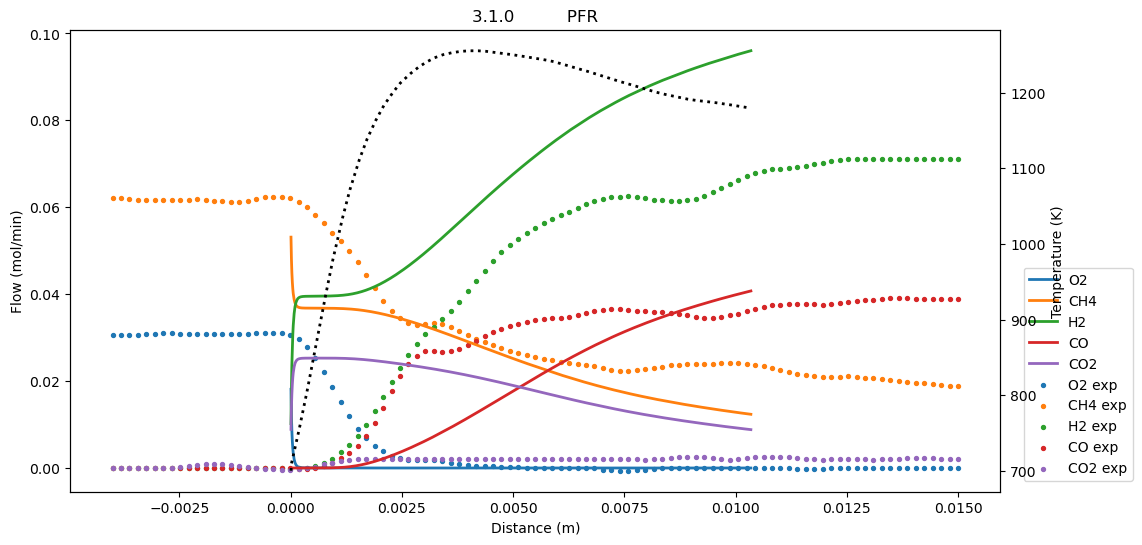

In [59]:
# Plot the result
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linewidth1 = 2.0
linewidth2 = 2.0

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

plt.plot(dist_array, gas_out[:, i_O2], label='O2', color=colors[0], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CH4], label='CH4', color=colors[1], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_H2], label='H2', color=colors[2], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CO], label='CO', color=colors[3], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CO2], label='CO2', color=colors[4], linewidth=linewidth2)

plt.scatter((df['Distance (mm)'].values - 10.0) / 1000.0, df['O2 (mol/min)'].values, label='O2 exp', color=colors[0], s=8)
plt.scatter((df['Distance (mm)'].values - 10.0) / 1000.0, df['CH4 (mol/min)'].values, label='CH4 exp', color=colors[1], s=8)
plt.scatter((df['Distance (mm)'].values - 10.0) / 1000.0, df['H2 (mol/min)'].values, label='H2 exp', color=colors[2], s=8)
plt.scatter((df['Distance (mm)'].values - 10.0) / 1000.0, df['CO (mol/min)'].values, label='CO exp', color=colors[3], s=8)
plt.scatter((df['Distance (mm)'].values - 10.0) / 1000.0, df['CO2 (mol/min)'].values, label='CO2 exp', color=colors[4], s=8)


ax1 = plt.gca()
ylim = ax1.get_ylim()
# Mark the catalyst extent
# plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 1.0], linestyle='--', color='xkcd:grey')
# plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 1.0], linestyle='--', color='xkcd:grey')
# plt.ylim(ylim)

ax2 = ax1.twinx()
ax2.plot(dist_array, T_array, label='Temperature', color='k', linestyle=':', linewidth=linewidth2)
ax2.set_ylabel('Temperature (K)')
# ax2.set_ylim((832.6458681304853, 1380.7048767073081))

ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Flow (mol/min)')
ax1.legend(bbox_to_anchor=(1.15, 0.5))
# ax1.set_ylim((-0.005686988947011412, 0.11942676788723965))
# ax1.set_xlim((-0.004950495049504951, 0.10396039603960397))

plt.title(ct.__version__ + f'          PFR')